# Vector Spherical Harmonics

## Preliminaries

### Definition

We use the following definition of the Vector Spherical Harmonics $\{\boldsymbol{Y}_l^m, \boldsymbol{\Psi}_l^m, \boldsymbol{\Phi}_l^m\}$:

$$
\begin{align*}
\boldsymbol{Y}_l^m & =Y_l^m \boldsymbol{e}_r, \\
\boldsymbol{\Psi}_l^m & =\nabla_S Y_l^m=\frac{\partial Y_l^m}{\partial \theta} \boldsymbol{e}_\theta+\frac{1}{\sin \theta} \frac{\partial Y_l^m}{\partial \varphi} \boldsymbol{e}_{\varphi}, \\
\boldsymbol{\Phi}_l^m & =\nabla_S Y_l^m \times \boldsymbol{e}_r=\frac{1}{\sin \theta} \frac{\partial Y_l^m}{\partial \varphi} \boldsymbol{e}_\theta-\frac{\partial Y_l^m}{\partial \theta} \boldsymbol{e}_{\varphi},
\end{align*}
$$

for $0 \leq |m| \leq l$ and note that $\boldsymbol{\Psi}_0^0 = \boldsymbol{\Phi}_0^0  = \boldsymbol{0}$.

The Vector Spherical Harmonics satisfy the following orthogonality properties:

$$
\begin{align*}
\int_{\mathbb{S}^2} \boldsymbol{Y}_l^m \cdot \overline{\boldsymbol{Y}_{l^{\prime}}^{m^{\prime}}} \, \mathrm{d} S &= \delta_{l l^{\prime}} \delta_{m m^{\prime}}, \\
\int_{\mathbb{S}^2} \boldsymbol{\Psi}_l^m \cdot \overline{\boldsymbol{\Psi}_{l^{\prime}}^{m^{\prime}}} \, \mathrm{d} S &= l(l+1) \delta_{l l^{\prime}} \delta_{m m^{\prime}}, \\
\int_{\mathbb{S}^2} \boldsymbol{\Phi}_l^m \cdot \overline{\boldsymbol{\Phi}_{l^{\prime}}^{m^{\prime}}} \, \mathrm{d} S &= l(l+1) \delta_{l l^{\prime}} \delta_{m m^{\prime}}.
\end{align*}
$$

### Vector Spherical Harmonic transform

For a velocity field $\boldsymbol{v}$ defined in spherical coordinates

$$
\boldsymbol{v}(\theta, \varphi)=u(\theta, \varphi) \boldsymbol{e}_r + v(\theta, \varphi) \boldsymbol{e}_\theta + w (\theta, \varphi) \boldsymbol{e}_{\varphi},
$$

we are interested in computing it's expansion in the Vector Spherical Harmonics. To achieve, we consider the projection integrals

$$
\begin{align*}
& \tilde{v}_{l m}^r=\int_{\mathbb{S}^2} u \overline{Y_l^m} \, \mathrm{d} S, \\
& \tilde{v}_{l m}^{s}=\frac{1}{l(l+1)}\left(\int_{\mathbb{S}^2} v \frac{\partial \overline{Y_l^m}}{\partial \theta} \, \mathrm{d} S + \int_{\mathbb{S}^2} w \frac{\partial \overline{Y_l^m}}{\partial \varphi} \frac{1}{\sin \theta} \, \mathrm{d} S\right), \\
& \tilde{v}_{l m}^{t}=\frac{1}{l(l+1)}\left(\int_{\mathbb{S}^2} v \frac{\partial \overline{Y_l^m}}{\partial \varphi} \frac{1}{\sin \theta} d S - \int_{\mathbb{S}^2} w \frac{\partial \overline{Y_l^m}}{\partial \theta} \, \mathrm{d} S\right).
\end{align*}
$$

We notice that the radial component is trivially transformed by the scalar Spherical Harmonic Transform. The spheroidal and toroidal components (denoted by the superscripts $s$ and $t$) require the evaluation of projection integrals involving derivatives of the Spherical Harmonics. We therefore need to develop methods to evaluate the following integrals numerically:

$$
\begin{align*}
\int_{\mathbb{S}^2} f \overline{Y_l^m} \, \mathrm{d} S, \quad
\int_{\mathbb{S}^2} f \frac{\partial \overline{Y_l^m}}{\partial \theta} \, \mathrm{d} S, \quad
\int_{\mathbb{S}^2} f \frac{\partial \overline{Y_l^m}}{\partial \varphi} \frac{1}{\sin \theta} \, \mathrm{d} S.
\end{align*}
$$


## Preparation

In [1]:
import torch
import torch.nn as nn
import torch.fft as fft
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../torch_harmonics")

cmap = 'twilight_shifted'

plt.rcParams["figure.figsize"] = (40,20)

As example, we will use windspeeds 10m above the ground. The data was obtained from the ERA5 dataset, courtesy of ECMWF.

In [2]:
data = torch.from_numpy(np.load('./data/windspeed10.npy')[0:2])

### Plotting
let us define some convenience routines for plotting:

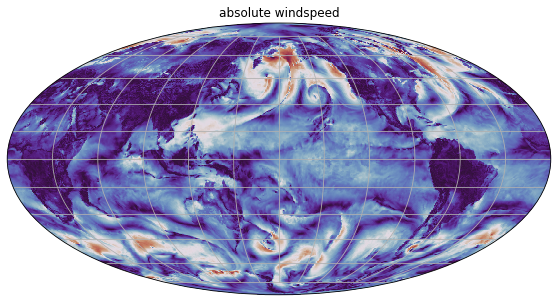

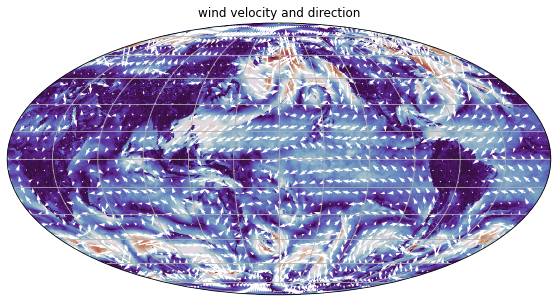

In [3]:
def plot_sphere(data, title=None):
    nlat = data.shape[-2]
    nlon = data.shape[-1]
    lon = np.linspace(-np.pi, np.pi, nlon)
    lat = np.linspace(np.pi/2., -np.pi/2., nlat)
    Lon, Lat = np.meshgrid(lon, lat)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection='mollweide')
    ax.pcolormesh(Lon, Lat, data, cmap=cmap)
    # ax.set_title("Elevation map of mars")
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title)
    plt.show()

def quiver_sphere(data, subsample=12, title=None):
    nlat = data.shape[-2]
    nlon = data.shape[-1]
    lon = np.linspace(-np.pi, np.pi, nlon)
    lat = np.linspace(np.pi/2., -np.pi/2., nlat)
    Lon, Lat = np.meshgrid(lon, lat)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection='mollweide')
    ax.pcolormesh(Lon, Lat, np.sqrt(data[0]**2+data[1]**2), cmap=cmap)
    ax.quiver(Lon[::subsample, ::subsample], Lat[::subsample, ::subsample], data[0, ::subsample, ::subsample], data[1, ::subsample, ::subsample], color='white')
    # ax.set_title("Elevation map of mars")
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title)
    plt.show()

plot_sphere(np.sqrt(data[0, 0]**2 + data[0, 1]**2), title='absolute windspeed')
quiver_sphere(data[0, 0:2], title='wind velocity and direction')

## Implementation

### Numerical integration

#### integral involving $\footnotesize \partial \overline{Y_l^m} / \partial \theta $

the first term is simply the scalar SHT, which we already know how to integrate. The second integral can be rewritten as

$$
\int_{\mathbb{S}^2} f \frac{\partial \overline{Y_l^m}}{\partial \theta} \, \mathrm{d} S = \int_{-1}^1 \frac{\partial }{\partial \theta} \hat{P}_l^m(\cos \theta)\int_0^{2\pi} f(\theta, \varphi) \exp(-im\varphi) \, \mathrm{d} \varphi \, \mathrm{d} \cos \theta.
$$

As with the scalar transform, the inner integral can be computed using the FFT. For $m > 0$, we can write

$$
\frac{\partial}{\partial \theta} \hat{P}_l^m(\cos \theta) = \frac{1}{2}\sqrt{(l+m)(l-m+1)} \hat{P}_l^{m-1}(\cos \theta) - \frac{1}{2}\sqrt{(l-m)(l+m+1)} \hat{P}_l^{m+1}(\cos \theta).
$$

Moreover, for $m=0, l$ we have
$$
\begin{align*}
\frac{\partial}{\partial \theta} \hat{P}_l^0(\cos \theta) &= - \sqrt{l(l+1)} \hat{P}_l^1(\cos \theta), \\
\frac{\partial}{\partial \theta} \hat{P}_l^l(\cos \theta) &= \sqrt{l/2} \, \hat{P}_l^{l-1}(\cos \theta).
\end{align*}
$$

The last property can be derived by

$$
\hat{P}_l^{-m}(\cos \theta) = (-1)^m \hat{P}_l^{m} \quad \text{ for } 0 < m \leq l.
$$

#### second integral involving $\footnotesize 1 / \sin \theta \, \partial \overline{Y_l^m} / \partial \varphi $

Similarly, with

$$
\frac{1}{\sin \theta}\frac{\partial \overline{Y_l^m}}{\partial \varphi} = im \exp(im \varphi) \frac{\hat{P}_l^m(\cos \theta)}{\sin \theta}
$$

we find that

$$
\int_{\mathbb{S}^2} f \frac{\partial \overline{Y_l^m}}{\partial \varphi} \frac{1}{\sin \theta}  \, \mathrm{d} S = -im \int_{-1}^1 \frac{\hat{P}_l^m(\cos \theta)}{\sin \theta} \int_0^{2\pi} f(\theta, \varphi) \exp(-im\varphi) \, \mathrm{d} \varphi \, \mathrm{d} \cos \theta.
$$

This requires the evaluation of $\hat{P}_l^m(\cos \theta)/\sin \theta$, which can be expressed in the following manner:

$$
\frac{\hat{P}_l^m(\cos \theta)}{\sin \theta} = \frac{1}{2 m} ()
$$

in `torch-harmonics`, there terms are computed for the quadrature, just as we did for $\hat{P}^m_l$ in the function `precompute_dlegpoly`:

In [4]:
from torch_harmonics.sht import *

In [5]:
nlat = data.shape[-2]
nlon = data.shape[-1]

cost_lg, wlg = legendre_gauss_weights(nlat, -1, 1)
tq = np.flip(np.arccos(cost_lg))

weights = torch.from_numpy(wlg)
mmax = nlon//2+1
lmax = nlat
pct = precompute_legpoly(mmax, lmax, tq)
dpct = precompute_dlegpoly(mmax, lmax, tq)


let us plot $\hat{P}^m_l$, its derivative $\partial \hat{P}_l^m / \partial \theta $ and $\hat{P}^m_l(\cos \theta) / \sin \theta$:

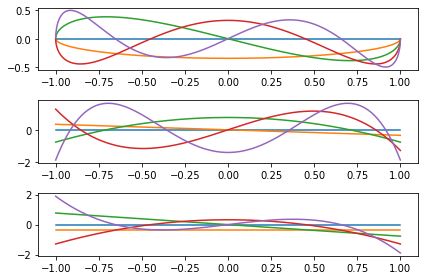

In [6]:
m = 1
nmax = 5

fig = plt.figure()
ax = fig.add_subplot(3, 1, 1)

for n in range(0, nmax):
    ax.plot(np.cos(tq), pct[m, n, :])

ax = fig.add_subplot(3, 1, 2)

for n in range(0, nmax):
    ax.plot(np.cos(tq), dpct[0, m, n, :])

ax = fig.add_subplot(3, 1, 3)

for n in range(0, nmax):
    ax.plot(np.cos(tq), dpct[1, m, n, :])

fig.tight_layout()

let us double-check that these are correct:

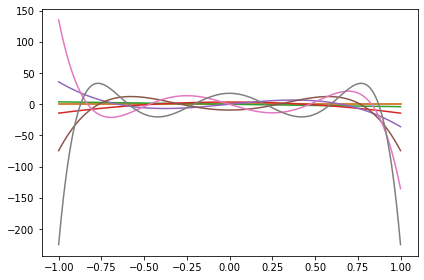

In [7]:
m = 1
lmax = 8

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for l in range(0, lmax):
    # ax.plot(np.cos(tq), l * (l+1) * dpct[1, m, l, :], ".")
    ax.plot(np.cos(tq), l * (l+1) * dpct[1, m, l, :] - m * pct[m, l, :] / np.sin(tq), "-")

fig.tight_layout()

In [8]:
sht  = RealSHT(nlat, nlon, grid='equiangular').float()
isht = InverseRealSHT(nlat, nlon, grid='equiangular').float()
vsht = RealVectorSHT(nlat, nlon, grid='equiangular').float()

using all these properties, we implement the VSHT. A nice property is that we can compute both vorticity and divergence by using the foward Vector SHT and the inverse SHT

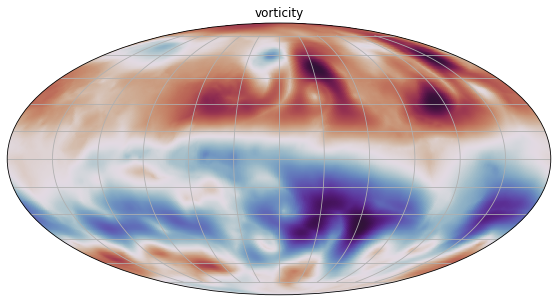

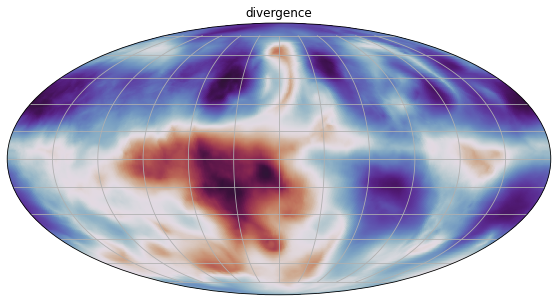

In [9]:
out = isht(vsht(data))
# plot vorticity and divergence:
plot_sphere(out[0, 0], title='vorticity')
plot_sphere(out[0, 1], title='divergence')

## Helmholtz-Hodge decomposition on the Sphere

In [10]:
import matplotlib.pyplot as plt
from matplotlib import colors
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm

def plot_ball(Lon, Lat):
    X, Y, Z = cartesian_coordinates(Lon, Lat)

    cmap = colors.LinearSegmentedColormap.from_list("", ["#76B900","#ffffff","#888888"])


    m, l = 6, 10

    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = sph_harm(m, l, Lat, Lon).real
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)

    # Set the aspect ratio to 1 so our sphere looks spherical
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect((2, 2, 1.8))
    # ax.set_aspect("equal")
    ax.view_init(40, 270)
    # ax.plot_wireframe(x, y, z, color='black')
    ax.plot_surface(X, Y, Z,  rstride=1, cstride=1, facecolors=cmap(fcolors), antialiased=True, shade=False)
    # Turn off the axis planes
    # ax.set_proj_type('ortho')
    ax.set_axis_off()
    # plt.show()

# plot_ball(Lon, Lat)